In [1]:
import numpy as np
import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_squared_log_error

In [2]:
# Paths
MODEL_PATH = "../Models"
os.makedirs(MODEL_PATH, exist_ok=True)

In [11]:
# Define Evaluation Function
from sklearn.metrics import root_mean_squared_error


def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluates a model and returns key metrics."""
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metrics = {
        "Training": {
            "R2": r2_score(y_train, y_train_pred),
            "MSE": mean_squared_error(y_train, y_train_pred),
            "RMSE": root_mean_squared_error(y_train, y_train_pred),  
            "MSLE": mean_squared_log_error(y_train, y_train_pred),
            "MAPE": mean_absolute_percentage_error(y_train, y_train_pred) * 100,
        },
        "Test": {
            "R2": r2_score(y_test, y_test_pred),
            "MSE": mean_squared_error(y_test, y_test_pred),
            "RMSE": root_mean_squared_error(y_test, y_test_pred),  
            "MSLE": mean_squared_log_error(y_test, y_test_pred),
            "MAPE": mean_absolute_percentage_error(y_test, y_test_pred) * 100,
        },
    }
    return metrics


In [6]:
# Load Dataset
# Update the dataset path as needed
df_path = "E:/Box Office Revenue Prediction/Datasets/preparedDataset.csv"
df = pd.read_csv(df_path)
print("Data loaded successfully. Sample:")
display(df.head())

Data loaded successfully. Sample:


,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


In [7]:
# Preprocess Data
# Make sure `feature_scaling2.prepare_features` is accessible or modify as needed
from feature_scaling import prepare_features  # Replace with your actual preprocessing function

X, y = prepare_features(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data preprocessed and split into training and testing sets.")

Data preprocessed and split into training and testing sets.


In [8]:
# Train Random Forest with Hyperparameter Tuning
param_grid = {
    "n_estimators": [100],
    "max_depth": [10],
    "min_samples_split": [10],
    "min_samples_leaf": [5],
    "max_features": ["log2", "sqrt"],
    "bootstrap": [True],
    
}
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring="r2", n_jobs=-1)
print("Training Random Forest with hyperparameter tuning...")
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best Random Forest Parameters:", grid_search.best_params_)

Training Random Forest with hyperparameter tuning...
Best Random Forest Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}


In [12]:
# Evaluate Random Forest
rf_metrics = evaluate_model(best_rf, X_train, X_test, y_train, y_test)
print("Random Forest Metrics:")
display(rf_metrics)

# Cross-Validation
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='r2', n_jobs=-1)
print("Cross-Validation R2 Scores:", cv_scores)
print("Mean CV R2 Score:", np.mean(cv_scores))

Random Forest Metrics:


{'Training': {'R2': 0.8123199529805185,
  'MSE': np.float64(0.6582546581031292),
  'RMSE': np.float64(0.8113289456830252),
  'MSLE': np.float64(0.0026981714331042583),
  'MAPE': np.float64(3.6031290832469365)},
 'Test': {'R2': 0.7149322918469436,
  'MSE': np.float64(1.07540312443767),
  'RMSE': np.float64(1.0370164533109734),
  'MSLE': np.float64(0.0042343400166057615),
  'MAPE': np.float64(4.719900535967476)}}

Cross-Validation R2 Scores: [0.5437252  0.62544137 0.68537773 0.70599014 0.59071851]
Mean CV R2 Score: 0.6302505918545497


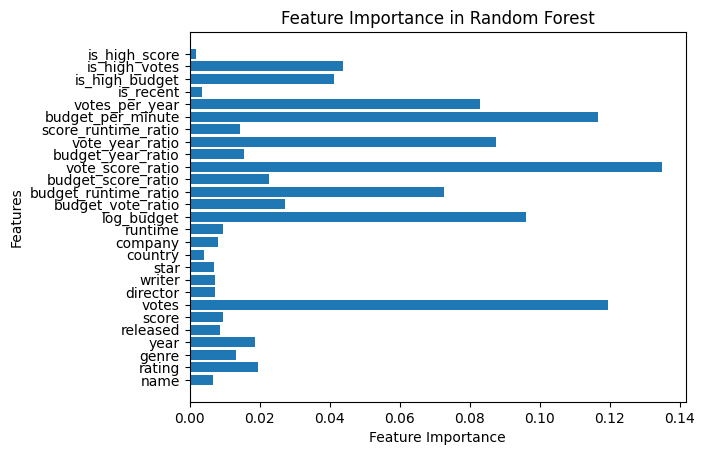

In [54]:

# Feature Importances
feature_importances = best_rf.feature_importances_
feature_names = X_train.columns
plt.barh(feature_names, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest")
plt.show()

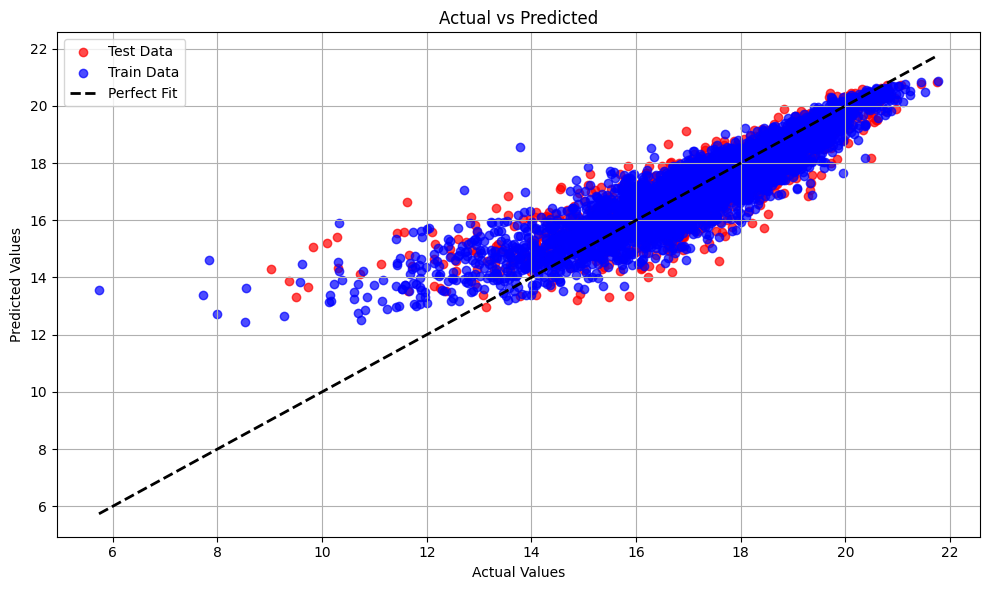

In [66]:
# Actual vs Predicted Plot
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred,color="red", alpha=0.7, label="Test Data")
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.7, label='Train Data')
# Reference Line
plt.plot(
    [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
    [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
    'k--',
    lw=2,
    label='Perfect Fit'
)
plt.title("Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [64]:
# Save the Random Forest model
model_file = "random_forest_model.pkl"
joblib.dump(best_rf, os.path.join(MODEL_PATH, "random_forest_model.pkl"))
print(f"Random Forest model saved to {MODEL_PATH}")

Random Forest model saved to ../Models
